In [10]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras.layers import GlobalAveragePooling1D, LSTM, MaxPooling1D, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape
import keras
from keras.layers import AveragePooling1D

from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numba

import dask.dataframe as dd
from dask.multiprocessing import get
from keras.layers import *
%matplotlib inline

In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [3]:
%%time 

train_df = pickle.load(open("cache/train_df_256_aug.pik","rb"))
valid_df = pickle.load(open("cache/valid_df_256.pik","rb"))
silent_df = pickle.load(open("cache/silent_df_256.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_256_aug.pik","rb"))


CPU times: user 13.9 s, sys: 18.7 s, total: 32.6 s
Wall time: 32.6 s


In [4]:
train_df.reset_index(inplace=True,drop=True)
valid_df.reset_index(inplace=True,drop=True)
unknown_df.reset_index(inplace=True,drop=True)
silent_df.reset_index(inplace=True,drop=True)

In [182]:


def train_generator(train_batch_size,selected_class ):
    


    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)

        this_train = pd.concat([this_train,
            silent_df.sample(extra_data_size) ,
                                unknown_df.sample(extra_data_size*2)],axis=0 )
        this_train["one_class_label"] = (this_train.label_id == selected_class).astype(int)
        

        this_train.reset_index(drop=True,inplace=True)
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
                y_batch.append(this_train.one_class_label.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = np.array(y_batch) #to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield x_batch, y_batch

In [183]:
%time t = next(train_generator(64,0))[1]
t

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 75.7 ms


array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [123]:

def valid_generator(val_batch_size,selected_class):
    valid_df["one_class_label"] = (valid_df.label_id == selected_class).astype(int)

    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.one_class_label.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = np.array(y_batch) #to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [7]:


def x_generator(test_df, test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
                x_batch.append(test_df.loc[i,'raw'].T)
            
            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            yield x_batch



### Model

In [184]:
p = 0.

def batch_relu(x):
    x = BatchNormalization()(x)    
    x = Activation('relu')(x)
    
    return x 

In [185]:
p = 0.0

def get_1dconvs_maxpool_freq_deep_fixed( x_in, kernel_size=10):
    
    x = BatchNormalization()(x_in)
    
    
    x = Conv1D(64,kernel_size,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(64,kernel_size,padding='same')(x)
    x = batch_relu(x)
    
    
    x = Dropout(p/2)(x)
    x  = MaxPooling1D(2)(x)   



    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)

    x = Dropout(p/2)(x)    
    x  = MaxPooling1D(2,name="frozen")(x) 
    

    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    
    x = Dropout(p/2)(x)    
    x  = MaxPooling1D(2)(x) 
    
    
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    x = Conv1D(128,3,padding='same')(x)
    x = batch_relu(x)
    
    x = Dropout(p/2)(x)     
    x  = AveragePooling1D(2)(x) 
    
    
    
    x_max = GlobalMaxPooling1D()(x)
#     x_avg = GlobalAveragePooling1D()(x)

#     x = concatenate([x_max,x_avg])
    
    return x_max

In [204]:
timesteps, input_dim , latent_dim = 32,256, 128

x_logml = Input(shape=(timesteps, input_dim)) #1 channel, 99 time, 161 freqs # S : np.ndarray [shape=(n_mels, t)]
x_freq = Reshape((input_dim, timesteps))(x_logml)



# 0.86
# xf_2= get_1dconvs_maxpool_freq_deep(x_freq,2)
xf_5 = get_1dconvs_maxpool_freq_deep_fixed(x_freq,10)

x = Dense(128, activation = 'relu')(xf_5) #
x = Dropout(0.3)(x)


x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)




In [187]:

# base_model = Model(inputs = x_logml, outputs = x)
# 

# seen_frozen = False
# for l in base_model.layers:
#     if l.name == "frozen":
#         seen_frozen = True
     
#     if not seen_frozen:
#         l.trainable = False

# base_model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
# base_model.load_weights("weights/conv1d_2xunk_kernel10.hdf5")

In [205]:
y = Dense(1, activation = 'sigmoid', name='ova_target')(x) #(base_model.layers[-2].output)
model = Model(inputs=[x_logml], outputs=[y])

In [206]:
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])


In [208]:
selected_class = 0 

In [209]:
exp_name = "freq1d_2xunk_onevsall_class_{}".format(selected_class)#max_freqconvs_2510_avgshortcuts
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
            ]

In [210]:
cw=  1 / (11 + 2.) 

In [196]:
1-cw

0.9230769230769231

Epoch 00005: reducing learning rate to 0.00010000000475.
329/329 [==============================] - 10s 29ms/step - loss: 0.0059 - acc: 0.9844 - val_loss: 0.0108 - val_acc: 0.9966

In [211]:
batch_size = 64

history = model.fit_generator(generator=train_generator(batch_size,selected_class),
                                      steps_per_epoch=train_df.shape[0]*(1./5)//batch_size,
                                      epochs=100,
                                      callbacks=callbacks,
                                      validation_data=valid_generator(batch_size,selected_class),
                                      validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)), 
                                      class_weight={0:cw, 1:(1-cw)})

Epoch 1/100
329/329 [==============================] - 22s 68ms/step - loss: 0.0784 - acc: 0.8030 - val_loss: 0.7615 - val_acc: 0.4847
Epoch 2/100
329/329 [==============================] - 17s 51ms/step - loss: 0.0702 - acc: 0.8159 - val_loss: 0.9628 - val_acc: 0.3094
Epoch 3/100
329/329 [==============================] - 17s 51ms/step - loss: 0.0628 - acc: 0.8484 - val_loss: 0.4774 - val_acc: 0.8369
Epoch 4/100
329/329 [==============================] - 17s 51ms/step - loss: 0.0557 - acc: 0.8825 - val_loss: 0.2837 - val_acc: 0.9512
Epoch 5/100
329/329 [==============================] - 17s 51ms/step - loss: 0.0515 - acc: 0.8886 - val_loss: 0.5038 - val_acc: 0.7960
Epoch 6/100
329/329 [==============================] - 17s 50ms/step - loss: 0.0506 - acc: 0.8906 - val_loss: 0.2893 - val_acc: 0.9369
Epoch 7/100
329/329 [==============================] - 17s 51ms/step - loss: 0.0421 - acc: 0.9192 - val_loss: 0.2403 - val_acc: 0.9459
Epoch 8/100
329/329 [==============================] - 

In [212]:

model.load_weights('./weights/{}.hdf5'.format(exp_name))

### valid evaluation

In [213]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [214]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

In [215]:
val_preds = model.predict_generator(valid_generator(64,selected_class),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds = val_preds > 0.5 # np.argmax(val_preds,axis=1)

In [201]:
val_preds.shape

(7055, 1)

In [216]:
y_true = (valid_df.label_id == selected_class).astype(int)

In [117]:
print classification_report(y_true,val_blend,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.95      0.96       261
         no       0.90      0.93      0.91       270
         up       0.91      0.94      0.93       260
       down       0.97      0.95      0.96       264
       left       0.96      0.98      0.97       247
      right       0.98      0.94      0.96       256
         on       0.91      0.94      0.93       257
        off       0.87      0.95      0.91       256
       stop       0.97      0.95      0.96       246
         go       0.92      0.89      0.91       260
    silence       1.00      1.00      1.00       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [44]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.95      0.97      0.96       261
         no       0.88      0.93      0.91       270
         up       0.90      0.93      0.91       260
       down       0.95      0.97      0.96       264
       left       0.92      0.98      0.95       247
      right       0.94      0.97      0.96       256
         on       0.90      0.95      0.93       257
        off       0.87      0.97      0.92       256
       stop       0.94      0.94      0.94       246
         go       0.87      0.92      0.90       260
    silence       0.99      1.00      1.00       257
    unknown       0.99      0.96      0.97      4221

avg / total       0.96      0.96      0.96      7055



In [217]:
print classification_report(y_true,val_preds,target_names=["others",id2name[selected_class]])

             precision    recall  f1-score   support

     others       0.99      0.99      0.99      6794
        yes       0.87      0.85      0.86       261

avg / total       0.99      0.99      0.99      7055



In [203]:
print classification_report(y_true,val_preds,target_names=["others",id2name[selected_class]])

             precision    recall  f1-score   support

     others       1.00      1.00      1.00      6794
        yes       0.95      0.97      0.96       261

avg / total       1.00      1.00      1.00      7055



In [67]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS) 

             precision    recall  f1-score   support

        yes       0.99      0.96      0.98       261
         no       0.94      0.92      0.93       270
         up       0.93      0.93      0.93       260
       down       0.95      0.95      0.95       264
       left       0.97      0.98      0.97       247
      right       0.95      0.96      0.96       256
         on       0.92      0.94      0.93       257
        off       0.93      0.94      0.93       256
       stop       0.96      0.95      0.95       246
         go       0.93      0.90      0.92       260
    silence       0.97      1.00      0.99       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [46]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.97      0.97      0.97       261
         no       0.91      0.91      0.91       270
         up       0.90      0.94      0.92       260
       down       0.93      0.95      0.94       264
       left       0.95      0.98      0.97       247
      right       0.92      0.97      0.95       256
         on       0.84      0.94      0.89       257
        off       0.89      0.96      0.92       256
       stop       0.94      0.96      0.95       246
         go       0.86      0.92      0.89       260
    silence       0.96      1.00      0.98       257
    unknown       0.99      0.96      0.97      4221

avg / total       0.96      0.96      0.96      7055



In [196]:
# 2xunk -timeconv-maxpool wlstm
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.87      0.93      0.90       270
         up       0.86      0.93      0.89       260
       down       0.92      0.94      0.93       264
       left       0.91      0.99      0.95       247
      right       0.93      0.96      0.94       256
         on       0.88      0.94      0.91       257
        off       0.88      0.94      0.91       256
       stop       0.95      0.93      0.94       246
         go       0.85      0.92      0.88       260
    silence       0.97      1.00      0.98       257
    unknown       0.99      0.96      0.97      4221

avg / total       0.96      0.95      0.96      7055



In [141]:
# 2xunk -timeconv-maxpool
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.96      0.96      0.96       261
         no       0.88      0.93      0.91       270
         up       0.86      0.92      0.89       260
       down       0.90      0.95      0.92       264
       left       0.89      0.98      0.93       247
      right       0.93      0.95      0.94       256
         on       0.87      0.92      0.90       257
        off       0.85      0.95      0.90       256
       stop       0.95      0.94      0.94       246
         go       0.83      0.90      0.86       260
    silence       0.96      1.00      0.98       257
    unknown       0.99      0.95      0.97      4221

avg / total       0.95      0.95      0.95      7055



In [102]:
# 2x unknown
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.96      0.95      0.96       261
         no       0.88      0.91      0.90       270
         up       0.80      0.95      0.87       260
       down       0.96      0.89      0.93       264
       left       0.90      0.96      0.93       247
      right       0.90      0.93      0.92       256
         on       0.93      0.88      0.90       257
        off       0.90      0.90      0.90       256
       stop       0.99      0.90      0.94       246
         go       0.85      0.92      0.88       260
    silence       0.97      1.00      0.98       257
    unknown       0.98      0.97      0.97      4221

avg / total       0.95      0.95      0.95      7055



In [28]:
# 2x unknown
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.97      0.97      0.97       261
         no       0.91      0.92      0.91       270
         up       0.83      0.95      0.89       260
       down       0.95      0.96      0.95       264
       left       0.93      0.98      0.96       247
      right       0.90      0.96      0.93       256
         on       0.88      0.95      0.91       257
        off       0.90      0.95      0.92       256
       stop       0.95      0.94      0.95       246
         go       0.90      0.92      0.91       260
    silence       0.98      1.00      0.99       257
    unknown       0.99      0.96      0.97      4221

avg / total       0.96      0.96      0.96      7055



In [106]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.97      0.98       261
         no       0.92      0.94      0.93       270
         up       0.93      0.95      0.94       260
       down       0.98      0.97      0.97       264
       left       0.96      0.99      0.97       247
      right       0.96      0.96      0.96       256
         on       0.93      0.96      0.94       257
        off       0.90      0.97      0.93       256
       stop       0.98      0.96      0.97       246
         go       0.92      0.91      0.91       260
    silence       0.99      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [42]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.90      0.92      0.91       270
         up       0.91      0.94      0.92       260
       down       0.95      0.96      0.96       264
       left       0.95      0.96      0.96       247
      right       0.96      0.97      0.96       256
         on       0.91      0.95      0.93       257
        off       0.92      0.94      0.93       256
       stop       0.97      0.94      0.95       246
         go       0.89      0.91      0.90       260
    silence       0.98      1.00      0.99       257
    unknown       0.98      0.97      0.98      4221

avg / total       0.96      0.96      0.96      7055



In [36]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.90      0.92      0.91       270
         up       0.91      0.94      0.92       260
       down       0.95      0.96      0.96       264
       left       0.95      0.96      0.96       247
      right       0.96      0.97      0.96       256
         on       0.91      0.95      0.93       257
        off       0.92      0.94      0.93       256
       stop       0.97      0.94      0.95       246
         go       0.89      0.91      0.90       260
    silence       0.98      1.00      0.99       257
    unknown       0.98      0.97      0.98      4221

avg / total       0.96      0.96      0.96      7055



In [113]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.97       261
         no       0.92      0.94      0.93       270
         up       0.89      0.93      0.91       260
       down       0.96      0.97      0.96       264
       left       0.95      0.99      0.97       247
      right       0.96      0.97      0.97       256
         on       0.91      0.95      0.93       257
        off       0.92      0.95      0.93       256
       stop       0.97      0.95      0.96       246
         go       0.93      0.93      0.93       260
    silence       0.99      1.00      0.99       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [63]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.91      0.94      0.92       270
         up       0.93      0.92      0.92       260
       down       0.93      0.97      0.95       264
       left       0.95      0.98      0.96       247
      right       0.95      0.95      0.95       256
         on       0.93      0.93      0.93       257
        off       0.87      0.95      0.91       256
       stop       0.96      0.94      0.95       246
         go       0.90      0.91      0.90       260
    silence       0.99      1.00      0.99       257
    unknown       0.98      0.97      0.98      4221

avg / total       0.96      0.96      0.96      7055



In [32]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.97      0.98       261
         no       0.91      0.93      0.92       270
         up       0.91      0.93      0.92       260
       down       0.97      0.95      0.96       264
       left       0.97      0.98      0.97       247
      right       0.97      0.94      0.96       256
         on       0.95      0.94      0.95       257
        off       0.94      0.96      0.95       256
       stop       0.97      0.91      0.94       246
         go       0.88      0.87      0.87       260
    silence       0.99      1.00      1.00       257
    unknown       0.98      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [176]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.92      0.93      0.92       270
         up       0.83      0.95      0.89       260
       down       0.95      0.96      0.96       264
       left       0.95      0.98      0.97       247
      right       0.97      0.95      0.96       256
         on       0.94      0.94      0.94       257
        off       0.90      0.95      0.92       256
       stop       0.96      0.94      0.95       246
         go       0.92      0.92      0.92       260
    silence       1.00      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [107]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.97      0.98       261
         no       0.89      0.92      0.90       270
         up       0.92      0.94      0.93       260
       down       0.96      0.97      0.96       264
       left       0.96      0.98      0.97       247
      right       0.97      0.97      0.97       256
         on       0.93      0.95      0.94       257
        off       0.92      0.97      0.94       256
       stop       0.97      0.94      0.96       246
         go       0.91      0.91      0.91       260
    silence       0.99      1.00      1.00       257
    unknown       0.99      0.98      0.98      4221

avg / total       0.97      0.97      0.97      7055



In [78]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.88      0.91      0.89       270
         up       0.86      0.95      0.90       260
       down       0.92      0.95      0.93       264
       left       0.94      0.98      0.96       247
      right       0.94      0.95      0.95       256
         on       0.83      0.94      0.88       257
        off       0.87      0.94      0.90       256
       stop       0.98      0.93      0.95       246
         go       0.80      0.90      0.85       260
    silence       0.95      1.00      0.98       257
    unknown       0.98      0.95      0.97      4221

avg / total       0.95      0.95      0.95      7055



In [41]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.96      0.97       261
         no       0.92      0.92      0.92       270
         up       0.93      0.93      0.93       260
       down       0.99      0.95      0.97       264
       left       0.98      0.97      0.97       247
      right       0.99      0.95      0.97       256
         on       0.97      0.92      0.95       257
        off       0.94      0.92      0.93       256
       stop       0.99      0.94      0.97       246
         go       0.95      0.88      0.92       260
    silence       0.97      1.00      0.98       257
    unknown       0.76      0.98      0.86       257

avg / total       0.95      0.94      0.94      3091



In [95]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.98      0.96      0.97       261
         no       0.92      0.94      0.93       270
         up       0.92      0.93      0.93       260
       down       0.98      0.94      0.96       264
       left       0.97      0.97      0.97       247
      right       0.95      0.96      0.96       256
         on       0.96      0.95      0.96       257
        off       0.94      0.92      0.93       256
       stop       1.00      0.94      0.97       246
         go       0.96      0.89      0.92       260
    silence       0.98      1.00      0.99       257
    unknown       0.82      0.95      0.88       257

avg / total       0.95      0.95      0.95      3091



In [19]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.95      0.97       261
         no       0.94      0.95      0.95       270
         up       0.92      0.95      0.93       260
       down       0.99      0.95      0.97       264
       left       0.97      0.96      0.96       247
      right       0.99      0.95      0.97       256
         on       0.99      0.92      0.95       257
        off       0.93      0.94      0.93       256
       stop       0.98      0.95      0.97       246
         go       0.94      0.90      0.92       260
    silence       0.99      1.00      1.00       257
    unknown       0.80      0.96      0.88       257

avg / total       0.95      0.95      0.95      3091



### submission


In [82]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [83]:
len(test_paths)

158538

In [50]:
test_df = pickle.load( open("cache/test_df_256.pik","rb"))


In [122]:
test_df.shape

(158538, 5)

In [84]:
def test_generator(test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
            #WATCHOUT > NO AUG
#                 x_batch.append(process_wav_file(x).T) #,reshape=False,augment=augment,pval=0.5))
                x_batch.append(test_df.loc[i,'raw'].T)

            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            
            yield x_batch

In [85]:
predictions = model.predict_generator(test_generator(batch_size), int(np.ceil(len(test_paths)/float(batch_size))), verbose=1)

2478/2478 [==============================] - 67s 27ms/step


In [86]:
np.save("cache/predictions_{}.npy".format(exp_name),predictions)

In [127]:
predictions.shape

(158538, 12)

#### blending

In [123]:
# predictions_pyramid_noaug = np.load('cache/predictions_pyramid_noaug.npy')
# predictions_model_with_ae_base_drp2_1 = np.load('cache/predictions_model_with_ae_base_drp2_1.npy')
blend1 = np.load('cache/predictions_blend_dilated_conv1d_timek123_n_freqk48_pseudo_mixtimefreq1ds_plus_samewithlstm_plus_aebased_conv2d_finetuned.npy')
# predictions_aebase_aug_drp3_finetune = np.load('cache/predictions_aebase_aug_drp3_finetune.npy')
# predictions_conv_n_lstm = np.load("cache/predictions_dilated_conv_n_lstm.npy")

In [124]:
blend2 = np.mean([predictions,
                       blend1], axis=0)


In [126]:
np.save("cache/predictions_{}.npy".format("frqmaxpool256_plus_longblend1"),blend2)

In [156]:
# num_aug = 2 
# for i in range(num_aug):
#     predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

# predictions = predictions/(num_aug + 1.0)

2477/2478 [============================>.] - ETA: 0s

#### class assignment

In [87]:
classes = np.argmax(predictions, axis=1)

In [88]:
classes.shape, len(test_paths)

((158538,), 158538)

(array([  11592.,    5042.,    5004.,    5542.,    5964.,    5972.,
           6256.,    5536.,    5239.,  102391.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

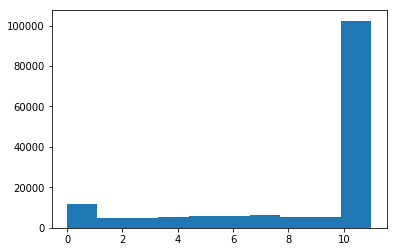

In [89]:
plt.hist(classes,bins=10)

### submission

In [90]:
### last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [91]:
with open('subm/{}.csv'.format(exp_name), 'w') as fout: #_blend_conv1dlstm_and_aebased_conv2d_finetuned
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))

In [92]:
from IPython.lib.display import FileLink

FileLink('subm/{}.csv'.format(exp_name))


/home/ubuntu/keyword_spotting/subm/timeconv5_freqconv10_wlstm128_pseudowval.csv